In [2]:
# module 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import copy

In [2]:
# dataset 로딩
x_train_load = pd.read_csv('C:\\Users\\zeus_\\Desktop\\champion_data\\train\\train_activity_new.csv').sort_values(by='acc_id', ascending=True)
y_train_load = pd.read_csv('C://Users//zeus_//Desktop//champion_data//train/train_label.csv').sort_values(by='acc_id', ascending=True)
x_test_load = pd.read_csv('C:\\Users\\zeus_\\Desktop\\champion_data\\test\\test_activity_new.csv').sort_values(by='acc_id', ascending=True)

## 중요 피처 뽑는 함수
- input: data_columns, feature_importances, num
- output: list
---

In [3]:
def select_important_feautre(columns, feature_importance, num):
    
    #딕셔너리
    dic = {}
    for value in [list(v) for v in zip(columns, feature_importance)]:
        dic[str(value[1])] = value[0] 
    
    #피처 중요도
    f_i = list(feature_importance)
    f_i.sort(reverse=True)
    
    
    #n개 뽑기
    result = ['acc_id']
    for i in range(0, num):
        result.append(dic[str(f_i[i])])
    
    return result

## 시작!
---

In [4]:
x_data = copy.deepcopy(x_train_load)
y_data = copy.deepcopy(y_train_load)
x_test = copy.deepcopy(x_test_load)

## feature engineering
---

#### 주차별 데이터
---

##### 채팅
- 1) 채팅횟수 총합 (1)
- 2) 채팅 비율 (5)

In [5]:
#채팅횟수 총합
x_data['sum_chat'] = x_data['normal_chat'] + x_data['whisper_chat'] + x_data['district_chat'] + x_data['party_chat'] + x_data['guild_chat'] + x_data['faction_chat']
x_test['sum_chat'] = x_test['normal_chat'] + x_test['whisper_chat'] + x_test['district_chat'] + x_test['party_chat'] + x_test['guild_chat'] + x_test['faction_chat']

In [6]:
#채팅 비율
temp = ['normal_chat', 'whisper_chat', 'district_chat', 'party_chat', 'guild_chat', 'faction_chat']
for value in temp:
    x_data['rate_' + value] = x_data[value]/(x_data['sum_chat'] + 0.0001)
    x_test['rate_' + value] = x_test[value]/(x_test['sum_chat'] + 0.0001)

##### 입장
- 1) 입장 총합 (1)
- 2) 입장 비율 (7)

In [7]:
#입장 총합
temp = ['inzone_solo', 'inzone_light', 'inzone_skilled', 'inzone_normal', 'raid', 'raid_light', 'bam']
x_data['sum_enter'] = 0
x_test['sum_enter'] = 0
for v in temp:
    x_data['sum_enter'] += x_data['cnt_enter_' + v]
    x_test['sum_enter'] += x_test['cnt_enter_' + v]

In [8]:
#입장 비율
temp = ['inzone_solo', 'inzone_light', 'inzone_skilled', 'inzone_normal', 'raid', 'raid_light', 'bam']
for value in temp:
    x_data['rate_enter_' + value] = x_data['cnt_enter_' + value]/(x_data['sum_enter'] + 0.0001)
    x_test['rate_enter_' + value] = x_test['cnt_enter_' + value]/(x_test['sum_enter'] + 0.0001)

##### 완료
- 1) 완료 총합 (1)
- 2) 완료 비율 (7)

In [9]:
#완료 총합
temp = ['inzone_solo', 'inzone_light', 'inzone_skilled', 'inzone_normal', 'raid', 'raid_light', 'bam']
x_data['sum_clear'] = 0
x_test['sum_clear'] = 0
for v in temp:
    x_data['sum_clear'] += x_data['cnt_clear_' + v]
    x_test['sum_clear'] += x_test['cnt_clear_' + v]

In [10]:
#완료 비율
temp = ['inzone_solo', 'inzone_light', 'inzone_skilled', 'inzone_normal', 'raid', 'raid_light', 'bam']
for value in temp:
    x_data['rate_clear_' + value] = x_data['cnt_clear_' + value]/(x_data['sum_clear'] + 0.0001)
    x_test['rate_clear_' + value] = x_test['cnt_clear_' + value]/(x_test['sum_clear'] + 0.0001)

##### 완료율
- 1) 완료율 (7)

In [11]:
#완료율
#솔로 인던 완료율, 라이트 인던 완료율, 숙련 인던 완료율, 라이트/숙련 인던 완료율, 레이드 완료율, 라이트 레이드 완료율, 바람 평야 완료율
temp = ['inzone_solo', 'inzone_light', 'inzone_skilled', 'inzone_normal', 'raid', 'raid_light', 'bam']
for value in temp:
    x_data['rate_' + value] = x_data['cnt_clear_' + value]/(x_data['cnt_enter_' + value] + 0.0001)
    x_test['rate_' + value] = x_test['cnt_clear_' + value]/(x_test['cnt_enter_' + value] + 0.0001)

##### 승률
- 1) 결투 승률 (1)
- 2) 전장 승률 (2)

In [12]:
#결투승률추가
x_data['duel_winning_rate'] = x_data.duel_win/(x_data.duel_cnt + 0.0001)
x_test['duel_winning_rate'] = x_test.duel_win/(x_test.duel_cnt + 0.0001)

In [13]:
#전장승률추가
x_data['partybattle_winning_rate'] = x_data.partybattle_win/(x_data.partybattle_cnt + 0.0001)
x_test['partybattle_winning_rate'] = x_test.partybattle_win/(x_test.partybattle_cnt + 0.0001)

##### 경험치
- 1) 총경험치 획득량 (1)
- 2) 각 경험치 획득 비율 (5)

In [14]:
#총 경험치 획득량
x_data['sum_exp'] = x_data['npc_exp'] + x_data['npc_hongmun'] + x_data['quest_exp'] + x_data['quest_hongmun'] + x_data['item_hongmun']
x_test['sum_exp'] = x_test['npc_exp'] + x_test['npc_hongmun'] + x_test['quest_exp'] + x_test['quest_hongmun'] + x_test['item_hongmun']

In [15]:
#각 경험치 획득 비율
temp = ['npc_exp', 'npc_hongmun', 'quest_exp', 'quest_hongmun', 'item_hongmun']
for value in temp:
        x_data['rate_' + value] = x_data[value]/(x_data['sum_exp'] + 0.0001)
        x_test['rate_' + value] = x_test[value]/(x_test['sum_exp'] + 0.0001)

###### play time 대비 ~

In [16]:
#play time - game combat time
x_data['p_to_g'] = x_data.play_time / (x_data.game_combat_time + 0.0001)
x_data['g_to_p'] = x_data.game_combat_time / (x_data.play_time + 0.0001)
x_data['b_to_p'] = x_data.cnt_use_buffitem / (x_data.play_time + 0.0001)

#play time - game combat time
x_test['p_to_g'] = x_test.play_time / (x_test.game_combat_time + 0.0001)
x_test['g_to_p'] = x_test.game_combat_time / (x_test.play_time + 0.0001)
x_test['b_to_p'] = x_test.cnt_use_buffitem / (x_test.play_time + 0.0001)

#### 통합 데이터
---

In [17]:
train_common = pd.DataFrame(index = x_data.groupby(by='acc_id').mean().index)
test_common = pd.DataFrame(index = x_test.groupby(by='acc_id').mean().index)

##### 평균 추가

In [18]:
train_mean = x_train_load.groupby(by='acc_id').mean().play_time.to_frame()
test_mean = x_test_load.groupby(by='acc_id').mean().play_time.to_frame()

In [19]:
train_mean.columns = [v + '_mean' for v in train_mean.columns]
test_mean.columns = [v + '_mean' for v in test_mean.columns]

In [20]:
train_common = pd.merge(train_common, train_mean, how='left', on='acc_id')
test_common = pd.merge(test_common, test_mean, how='left', on='acc_id')

###### 최대값 추가

In [21]:
train_max = x_train_load.groupby(by='acc_id').max().play_time.to_frame().fillna(-1000)
test_max = x_test_load.groupby(by='acc_id').max().play_time.to_frame().fillna(-1000)

In [22]:
train_max.columns = [v + '_max' for v in train_max.columns]
test_max.columns = [v + '_max' for v in test_max.columns]

In [23]:
train_max = pd.merge(train_common, train_max, how='left', on='acc_id')
test_max = pd.merge(test_common, test_max, how='left', on='acc_id')

###### 최소값 추가

In [24]:
train_min = x_train_load.groupby(by='acc_id').min().play_time.to_frame().fillna(-1000)
test_min = x_test_load.groupby(by='acc_id').min().play_time.to_frame().fillna(-1000)

In [25]:
train_min.columns = [v + '_min' for v in train_min.columns]
test_min.columns = [v + '_min' for v in test_min.columns]

In [26]:
train_common = pd.merge(train_common, train_min, how='left', on='acc_id')
test_common = pd.merge(test_common, test_min, how='left', on='acc_id')

##### duration_week

In [27]:
train_common['duration_wk'] = 8 - x_data.groupby(by='acc_id').min().wk
test_common['duration_wk'] = 8 - x_test.groupby(by='acc_id').min().wk

#### 주차별로 늘이기
---

In [28]:
x_data_temp = x_data[x_data.wk == 1]
x_test_temp = x_test[x_test.wk == 1]

x_data_temp.columns = x_data_temp.columns.map(lambda v: v + '_1' if v != 'acc_id' else v)
x_test_temp.columns = x_test_temp.columns.map(lambda v: v + '_1' if v != 'acc_id' else v)

for i in range(2, 9):
    x_data_i = x_data[x_data.wk == i]
    x_data_i.columns = x_data_i.columns.map(lambda v: v + '_' + str(i) if v != 'acc_id' else v)
    x_data_temp = pd.merge(x_data_temp, x_data_i, how = 'outer', on = 'acc_id')
    
    x_test_i = x_test[x_test.wk == i]
    x_test_i.columns = x_test_i.columns.map(lambda v: v + '_' + str(i) if v != 'acc_id' else v)
    x_test_temp = pd.merge(x_test_temp, x_test_i, how = 'outer', on = 'acc_id')

x_data = x_data_temp.fillna(0).sort_values(by='acc_id', ascending=True)
x_test = x_test_temp.fillna(0).sort_values(by='acc_id', ascending=True)

#### 합치기
---

In [29]:
x_data = x_data.set_index('acc_id')
x_test = x_test.set_index('acc_id')

In [30]:
x_data = pd.merge(x_data, train_common, how='left', on='acc_id')
x_test = pd.merge(x_test, test_common, how='left', on='acc_id')

#### play_time_mean month로부터의 거리
---

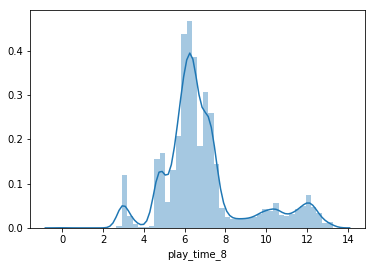

In [32]:
sns.distplot(np.log(x_data[(y_data.label == '2month').values].play_time_8))

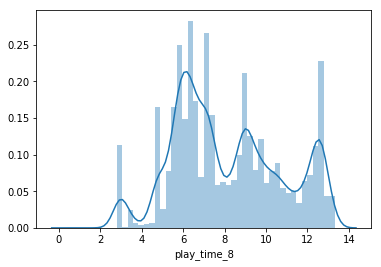

In [33]:
sns.distplot(np.log(x_data[(y_data.label == 'month').values].play_time_8))

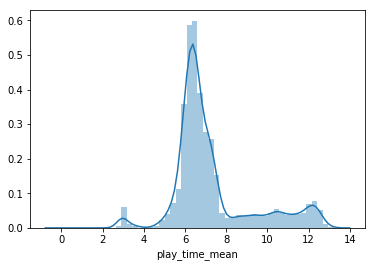

In [34]:
sns.distplot(np.log(x_data[(y_data.label == '2month').values].play_time_mean))

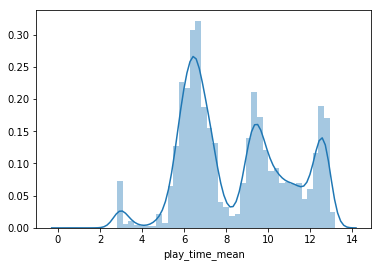

In [35]:
sns.distplot(np.log(x_data[(y_data.label == 'month').values].play_time_mean))

In [31]:
x_data['distance_play_time_mean'] = np.exp(15) - x_data.play_time_mean

# 저장 !
---

In [32]:
x_data.to_csv('C:\\Users\\zeus_\\Desktop\\champion_data\\train\\train_activity_final_v1.csv')
x_test.to_csv('C:\\Users\\zeus_\\Desktop\\champion_data\\test\\test_activity_final_v1.csv')

# 모델

# 트레이닝셋, 테스트 셋 구분
---

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_data.values, y_data.label.values, test_size=0.1, random_state=200)

---
# 모델 - 전체
---

In [38]:
forest = RandomForestClassifier(n_estimators=100, random_state=24, n_jobs=3, max_depth=32)

In [39]:
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [40]:
np.mean(f1_score(y_test, forest.predict(x_test), average=None))

0.7364499806235247

In [41]:
# plot_feature_importances(forest, x_test.columns)

In [42]:
select_important_feautre(x_data.columns, forest.feature_importances_, 200)

['acc_id',
 'play_time_mean',
 'play_time_8',
 'distance_play_time_mean',
 'p_to_g_8',
 'play_time_min',
 'cnt_dt_8',
 'game_combat_time_8',
 'sum_exp_8',
 'g_to_p_8',
 'get_money_8',
 'p_to_g_7',
 'play_time_7',
 'b_to_p_8',
 'p_to_g_4',
 'play_time_4',
 'play_time_5',
 'p_to_g_5',
 'p_to_g_6',
 'play_time_6',
 'p_to_g_3',
 'cnt_enter_inzone_normal_8',
 'rate_enter_inzone_normal_8',
 'play_time_3',
 'quest_hongmun_8',
 'cnt_dt_4',
 'rate_clear_inzone_normal_8',
 'rate_quest_hongmun_8',
 'get_money_3',
 'cnt_dt_7',
 'rate_npc_hongmun_8',
 'p_to_g_1',
 'npc_hongmun_8',
 'play_time_1',
 'play_time_2',
 'p_to_g_2',
 'cnt_dt_5',
 'sum_clear_8',
 'rate_clear_inzone_light_8',
 'rate_enter_raid_light_8',
 'sum_chat_8',
 'get_money_1',
 'duration_wk',
 'cnt_use_buffitem_8',
 'npc_exp_8',
 'sum_enter_8',
 'rate_guild_chat_7',
 'quest_exp_8',
 'cnt_clear_inzone_normal_8',
 'cnt_dt_6',
 'cnt_clear_raid_light_7',
 'guild_chat_8',
 'guild_chat_7',
 'cnt_dt_1',
 'rate_raid_light_8',
 'g_to_p_7',
 'g

In [43]:
# 테스트 데이터 로드
test_data = pd.read_csv('C://Users//zeus_//Desktop//champion_data//test/test_activity_final_v1.csv')

In [44]:
acc_id = test_data.acc_id.values

In [45]:
x_test = test_data.drop(['acc_id'], axis=1)

In [ ]:
result = forest.predict(x_test)

In [ ]:
data = {'acc_id':acc_id, 'label':result}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('C:\\Users\\zeus_\\Desktop\\champion_data\\test\\result\\40_final_v1_result.csv')